In [3]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve


import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
pd.set_option('display.width', 250)

In [5]:
# file path
eeg_path = 'Dataset/EEG_data.csv'
demographic_path = 'Dataset/demographic_info.csv'

In [6]:
# load eeg data
eeg_df = pd.read_csv(eeg_path)
eeg_df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


In [7]:
features = [
            'SubjectID', 'VideoID', 
            'Attention', 'Mediation', 
            'Raw', 'Delta', 'Theta', 'Alpha1', 
            'Alpha2', 'Beta1', 'Beta2', 'Gamma1',	
            'Gamma2', 'predefined', 'userdefined'
            ]

In [8]:
eeg_df.columns  = features

In [9]:
eeg_df.dtypes

SubjectID      float64
VideoID        float64
Attention      float64
Mediation      float64
Raw            float64
Delta          float64
Theta          float64
Alpha1         float64
Alpha2         float64
Beta1          float64
Beta2          float64
Gamma1         float64
Gamma2         float64
predefined     float64
userdefined    float64
dtype: object

In [10]:
eeg_df.describe()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefined,userdefined
count,12811.000000,12811.000000,12811.000000,12811.000000,12811.000000,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,12811.000000,12811.000000
mean,4.487394,4.390602,41.313871,47.182656,65.570760,6.057853e+05,1.680526e+05,4.138435e+04,3.318339e+04,2.431837e+04,3.814433e+04,2.959255e+04,1.441597e+04,0.479978,0.512606
std,2.865373,2.913232,23.152953,22.655976,597.921035,6.376236e+05,2.441346e+05,7.243082e+04,5.831410e+04,3.837968e+04,7.906606e+04,7.982637e+04,3.603523e+04,0.499618,0.499861
min,0.000000,0.000000,0.000000,0.000000,-2048.000000,4.480000e+02,1.700000e+01,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,0.000000,0.000000
25%,2.000000,2.000000,27.000000,37.000000,-14.000000,9.806400e+04,2.691750e+04,6.838000e+03,6.852000e+03,6.140000e+03,7.358500e+03,4.058000e+03,2.167500e+03,0.000000,0.000000
50%,4.000000,4.000000,43.000000,51.000000,35.000000,3.954870e+05,8.133100e+04,1.750000e+04,1.495900e+04,1.281800e+04,1.581000e+04,9.763000e+03,5.116000e+03,0.000000,1.000000
75%,7.000000,7.000000,57.000000,63.000000,90.000000,9.166230e+05,2.052760e+05,4.477950e+04,3.455050e+04,2.740600e+04,3.549400e+04,2.488800e+04,1.266950e+04,1.000000,1.000000
max,9.000000,9.000000,100.000000,100.000000,2047.000000,3.964663e+06,3.007802e+06,1.369955e+06,1.016913e+06,1.067778e+06,1.645369e+06,1.972506e+06,1.348117e+06,1.000000,1.000000


In [11]:
eeg_df['userdefined'].unique()

array([0., 1.])

In [12]:
# only numeric values
df = eeg_df.apply(pd.to_numeric)

In [13]:
demographic_df = pd.read_csv(demographic_path)
demographic_df.head()

,subject ID,age,ethnicity,gender
0,0,25,Han Chinese,M
1,1,24,Han Chinese,M
2,2,31,English,M
3,3,28,Han Chinese,F
4,4,24,Bengali,M


In [14]:
demographic_df.dtypes

subject ID     int64
 age           int64
 ethnicity    object
 gender       object
dtype: object

In [15]:
demographic_df.describe()

,subject ID,age
count,10.00000,10.000000
mean,4.50000,25.400000
std,3.02765,2.319004
min,0.00000,24.000000
25%,2.25000,24.000000
50%,4.50000,24.500000
75%,6.75000,25.000000
max,9.00000,31.000000


In [16]:
# drop ethnicity
demographic_df.drop(columns={' ethnicity'}, inplace=True)

In [17]:
# changing the name
demographic_df.columns = ['SubjectID', 'Age', 'Gender']


In [18]:
# gender F = 0 | M = 1
demographic_df['Gender'] = demographic_df['Gender'].map({'F': 0, 'M': 1})

In [19]:
demographic_df.dtypes

SubjectID    int64
Age          int64
Gender       int64
dtype: object

In [20]:
# merge to dataframe
merged_df = pd.merge(eeg_df, demographic_df, on='SubjectID', how='inner')
merged_df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefined,userdefined,Age,Gender
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0,25,1
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0,25,1
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0,25,1
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0,25,1
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0,25,1


In [21]:
# calculate corelation
correlation_matrix = merged_df[features[2:]].corr()
print(correlation_matrix)

             Attention  Mediation       Raw     Delta     Theta    Alpha1    Alpha2     Beta1     Beta2    Gamma1    Gamma2  predefined  userdefined
Attention     1.000000   0.548606 -0.094933 -0.220403 -0.258356 -0.198662 -0.247011 -0.255361 -0.306624 -0.299903 -0.312734    0.001559    -0.119088
Mediation     0.548606   1.000000 -0.106923 -0.111810 -0.179887 -0.043275 -0.153740 -0.240774 -0.391365 -0.344922 -0.373253    0.015751    -0.023502
Raw          -0.094933  -0.106923  1.000000  0.048908  0.053443  0.045247  0.063867  0.090863  0.173631  0.186884  0.205772    0.010598    -0.001465
Delta        -0.220403  -0.111810  0.048908  1.000000  0.483386  0.426530  0.409898  0.395217  0.260820  0.210062  0.218673    0.012333     0.148588
Theta        -0.258356  -0.179887  0.053443  0.483386  1.000000  0.586956  0.553796  0.555541  0.368975  0.300468  0.308575    0.001602     0.147558
Alpha1       -0.198662  -0.043275  0.045247  0.426530  0.586956  1.000000  0.565232  0.549113  0.317923  0

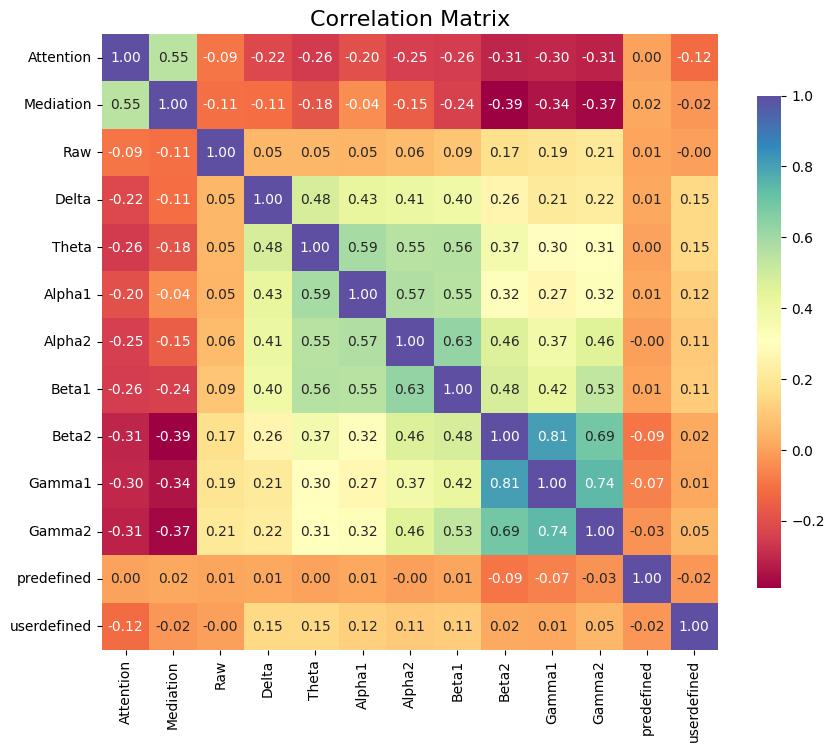

In [22]:
# visualize the correlation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True,       
            fmt=".2f",          
            cmap='Spectral',   
            square=True,        
            cbar_kws={"shrink": 0.8})  
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [24]:
# Mask the diagonal and find the maximum correlation
mask = np.eye(correlation_matrix.shape[0], dtype=bool)
corr_values = correlation_matrix.where(~mask)

max_corr = corr_values.max().max()
print(f"Max correlation (excluding self-correlation): {max_corr}")


Max correlation (excluding self-correlation): 0.8089304500960287


In [25]:
merged_df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefined,userdefined,Age,Gender
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0,25,1
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0,25,1
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0,25,1
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0,25,1
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0,25,1


In [28]:
selected_features = [
    'Attention', 'Mediation', 
    'Delta', 'Theta', 'Alpha1', 
    'Alpha2', 'Beta1', 'Beta2',
    'Gamma1', 'Gamma2', 'Age',
    'predefined'
]

In [29]:
# data preparation for lstm
X = merged_df[selected_features].values
y = merged_df['userdefined'].values

In [30]:
# calculate timestamp
info_df = merged_df[['SubjectID', 'VideoID']].copy()

timestamps = []
for (subj, vid), group in info_df.groupby(['SubjectID', 'VideoID']):
    n_samples = len(group)
    group_times = [i * 0.5 for i in range(n_samples)]
    timestamps.extend(group_times)

merged_df['Timestamp_sec'] = timestamps
info_df['Timestamp_sec'] = timestamps
merged_df.head()


,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefined,userdefined,Age,Gender,Timestamp_sec
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0,25,1,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0,25,1,0.5
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0,25,1,1.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0,25,1,1.5
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0,25,1,2.0


In [31]:
merged_df.to_csv('timestamp.csv', index=False)

In [32]:
W = 10  

X_seq, y_seq, info_seq = [], [], []
for (subj, vid), grp in merged_df.groupby(['SubjectID','VideoID']):
    data       = grp[features].values           # shape=(120, F)
    labels     = grp['userdefined'].values       # shape=(120,)
    timestamps = grp['Timestamp_sec'].values     # shape=(120,)

    for i in range(len(grp) - W + 1):
        X_seq.append(data[i:i+W])
        y_seq.append(int(labels[i:i+W].mean() > 0.5))
        # pick the middle‐of‐window timestamp
        info_seq.append({
            'SubjectID':    subj,
            'VideoID':      vid,
            'Timestamp_sec': timestamps[i + W//2]
        })

X_seq       = np.stack(X_seq)                   # → (n_windows, W, F)
y_seq       = np.array(y_seq)                   # → (n_windows,)
info_seq_df = pd.DataFrame(info_seq)            # → (n_windows, 3)

print(X_seq.shape, y_seq.shape, info_seq_df.shape)

(11911, 10, 15) (11911,) (11911, 3)


In [33]:
# split the train and test set
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test, info_train, info_test = train_test_split(
    X_seq, y_seq, info_seq_df,
    test_size=0.2,
    random_state=42,
    stratify=y_seq
)

print("Train shapes:", X_train.shape, y_train.shape, info_train.shape)
print("Test  shapes:", X_test.shape,  y_test.shape,  info_test.shape)


Train shapes: (9528, 10, 15) (9528,) (9528, 3)
Test  shapes: (2383, 10, 15) (2383,) (2383, 3)


In [263]:
n_tr, _, n_feat = X_train.shape
scaler = StandardScaler()
X_tr_flat = X_train.reshape(-1, n_feat)
X_tr_scaled = scaler.fit_transform(X_tr_flat).reshape(n_tr, W, n_feat)

n_te = X_test.shape[0]
X_te_flat = X_test.reshape(-1, n_feat)
X_te_scaled = scaler.transform(X_te_flat).reshape(n_te, W, n_feat)

from sklearn.utils import class_weight

cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
cw = {0: cw[0], 1: cw[1]}
print("Class weights:", cw)

Class weights: {0: 1.026281775096941, 1: 0.9750306999590668}


In [264]:
# default lstm
def build_lstm_model(input_shape, units=128, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential([
        Bidirectional(LSTM(units, return_sequences=True), input_shape=input_shape),
        Dropout(dropout_rate),
        Bidirectional(LSTM(units, return_sequences=True)),
        Dropout(dropout_rate),
        LSTM(units//2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model

In [265]:
def run_kfold_experiment(X, y, model_type, folder, k_splits=10, 
                         epochs=15, batch_size=256, 
                         callbacks=None):
    kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)
    results = []
    if X.ndim == 2:
        X = X.reshape((X.shape[0], 1, X.shape[1]))
    input_shape = (X.shape[1], X.shape[2])
    fold_no = 0
    os.makedirs(folder, exist_ok=True)
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), start=1):
        print(f"Training fold {fold}/{k_splits}...")
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model = model_type(input_shape)
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            callbacks=callbacks or []
        )   
        model.save(f'{folder}/lstm_fold_{fold_no}.h5')

        loss, acc = model.evaluate(X_val, y_val, verbose=0)
        print(f"Fold {fold} - Loss: {loss:.4f}, Accuracy: {acc:.4f}")
        results.append((loss, acc))

        fold_no += 1
        
    return results

In [37]:
default_folder = 'Default'
tuned_folder = 'Tuned'

In [ ]:
# training the model with default model
default_lstm = lambda input_shape: build_lstm_model(input_shape)

default_results = run_kfold_experiment(
    X_train, y_train, 
    model_type=default_lstm, 
    folder=default_folder,
    epochs=50,
    batch_size=128
)

Training fold 1/10...


C:\Users\tasni\miniconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Fold 1 - Loss: 0.5643, Accuracy: 0.6779
Training fold 2/10...
Fold 2 - Loss: 0.5599, Accuracy: 0.6894
Training fold 3/10...
Fold 3 - Loss: 0.5631, Accuracy: 0.6852
Training fold 4/10...
Fold 4 - Loss: 0.5590, Accuracy: 0.7041
Training fold 5/10...
Fold 5 - Loss: 0.5624, Accuracy: 0.6894
Training fold 6/10...
Fold 6 - Loss: 0.5822, Accuracy: 0.6842
Training fold 7/10...
Fold 7 - Loss: 0.5701, Accuracy: 0.6884
Training fold 8/10...
Fold 8 - Loss: 0.5962, Accuracy: 0.6569
Training fold 9/10...
Fold 9 - Loss: 0.5417, Accuracy: 0.6943
Training fold 10/10...
Fold 10 - Loss: 0.5800, Accuracy: 0.6838


In [ ]:
tuned_lstm = lambda input_shape: build_lstm_model(
    input_shape,
    units=256,
    dropout_rate=0.3,
    learning_rate=5e-4
)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


tuned_results = run_kfold_experiment(
    X_train, y_train,
    model_type=tuned_lstm,
    folder=tuned_folder,
    epochs=100,
    batch_size=128,
    callbacks=[early_stop]
)


Training fold 1/10...
Fold 1 - Loss: 0.2058, Accuracy: 0.9003
Training fold 2/10...
Fold 2 - Loss: 0.2823, Accuracy: 0.8594
Training fold 3/10...
Fold 3 - Loss: 0.2832, Accuracy: 0.8499
Training fold 4/10...
Fold 4 - Loss: 0.3120, Accuracy: 0.8300
Training fold 5/10...
Fold 5 - Loss: 0.2143, Accuracy: 0.9035
Training fold 6/10...
Fold 6 - Loss: 0.2444, Accuracy: 0.8940
Training fold 7/10...
Fold 7 - Loss: 0.2870, Accuracy: 0.8741
Training fold 8/10...
Fold 8 - Loss: 0.4097, Accuracy: 0.7786
Training fold 9/10...
Fold 9 - Loss: 0.2632, Accuracy: 0.8634
Training fold 10/10...
Fold 10 - Loss: 0.2511, Accuracy: 0.8761


In [34]:
# training summary
print("\nDefault model Results:")
print(f"Mean Loss: {np.mean(default_results):.4f}")
print(f"Std Dev: {np.std(default_results):.4f}")

print("\nTuned model Results:")
print(f"Mean Loss: {np.mean(tuned_results):.4f}")
print(f"Std Dev: {np.std(tuned_results):.4f}")



Default model Results:


NameError: name 'default_results' is not defined

In [269]:
# find the best fold default
losses_default = [r[0] for r in default_results] 
accuracies_default = [r[1] for r in default_results] 

# best model based on the loss
best_fold_idx_default = np.argmin(losses_default)
best_fold_no_default = best_fold_idx_default
print(f"\nBest fold based on Loss: Fold {best_fold_no_default} with Loss {losses_default[best_fold_idx_default]:.4f}")

# best model based on accuracy
best_fold_idx_acc_default = np.argmax(accuracies_default)
best_fold_no_acc_default = best_fold_idx_acc_default 

print(f"Best fold based on Accuracy: Fold {best_fold_no_acc_default} with Accuracy {accuracies_default[best_fold_idx_acc_default]:.4f}")


Best fold based on Loss: Fold 8 with Loss 0.5417
Best fold based on Accuracy: Fold 3 with Accuracy 0.7041


In [270]:
# find the best fold tuned
print(f"Tuned results")
losses_tuned = [r[0] for r in tuned_results] 
accuracies_tuned = [r[1] for r in tuned_results] 

# best model based on the loss
best_fold_idx_tuned = np.argmin(losses_tuned)
best_fold_no_tuned = best_fold_idx_tuned 
print(f"\nBest fold based on Loss: Fold {best_fold_no_tuned} with Loss {losses_tuned[best_fold_idx_tuned]:.4f}")

# best model based on accuracy
best_fold_idx_acc_tuned = np.argmax(accuracies_tuned)
best_fold_no_acc_tuned = best_fold_idx_acc_tuned 

print(f"Best fold based on Accuracy: Fold {best_fold_no_acc_tuned} with Accuracy {accuracies_tuned[best_fold_idx_acc_tuned]:.4f}")

Tuned results

Best fold based on Loss: Fold 0 with Loss 0.2058
Best fold based on Accuracy: Fold 4 with Accuracy 0.9035


In [41]:
best_fold_no_default = 8
best_fold_no_tuned = 0
best_model_default = load_model(f'{default_folder}/lstm_fold_{best_fold_no_default}.h5')
best_model_tuned = load_model(f'{tuned_folder}/lstm_fold_{best_fold_no_tuned}.h5')

In [42]:
# test the model default
# X_test_for_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

test_loss_default, test_acc_default = best_model_default.evaluate(X_test,
                                                   y_test, verbose=1)
print(f"Test loss: {test_loss_default:.4f}, Test accuracy: {test_acc_default:.4f}")

y_pred_prob_default = best_model_default.predict(X_test).flatten()
print("Predicted probabilities for default model:", y_pred_prob_default[:10])

y_pred_class_default = (y_pred_prob_default > 0.40).astype(int)
print(np.unique(y_pred_class_default))


75/75 [==============================] - 2s 6ms/step - loss: 0.5717 - accuracy: 0.6886
Test loss: 0.5717, Test accuracy: 0.6886
75/75 [==============================] - 2s 6ms/step
Predicted probabilities for default model: [0.67825115 0.3572937  0.6388272  0.6592049  0.80956376 0.3569278
 0.8383872  0.4837555  0.5386664  0.5654478 ]
[0 1]


In [43]:
# tuned model
test_loss_tuned, test_acc_tuned = best_model_tuned.evaluate(X_test,
                                                   y_test, verbose=1)
print(f"Test loss: {test_loss_tuned:.4f}, Test accuracy: {test_acc_tuned:.4f}")

y_pred_prob_tuned = best_model_tuned.predict(X_test).flatten()
print("Predicted probabilities for tuned model:", y_pred_prob_tuned[:10])

y_pred_class_tuned = (y_pred_prob_tuned > 0.40).astype(int)
print(np.unique(y_pred_class_tuned))

75/75 [==============================] - 2s 12ms/step - loss: 0.2425 - accuracy: 0.8943
Test loss: 0.2425, Test accuracy: 0.8943
75/75 [==============================] - 2s 12ms/step
Predicted probabilities for tuned model: [1.9012859e-02 5.4921334e-06 9.5866555e-01 6.0465503e-03 9.9957621e-01
 5.6044715e-03 9.8544121e-01 9.1276991e-01 1.3602816e-05 9.2735600e-01]
[0 1]


In [44]:
if X_test.ndim == 3:
    X_test_2d = X_test[:, 0, :]  
else:
    X_test_2d = X_test 
result_df = pd.DataFrame(X_test_2d, columns=features)
result_df['True_Label'] = y_test
result_df['Predicted_Prob_default'] = y_pred_prob_default
result_df['Predicted_Label_default'] = y_pred_class_default
result_df['Predicted_Prob_tuned'] = y_pred_prob_tuned
result_df['Predicted_Label_tuned'] = y_pred_class_tuned
result_df = pd.concat([
                        info_test.reset_index(drop=True), 
                        result_df.reset_index(drop=True)
                        ], axis=1)

result_df.to_csv('test_results.csv', index=False)

In [45]:
# Evaluate the model
accuracy_d = accuracy_score(y_test, y_pred_class_default)
f1_d = f1_score(y_test, y_pred_class_default)
precision_d = precision_score(y_test, y_pred_class_default)
recall_d = recall_score(y_test, y_pred_class_default)

print(f"Test results for the default model\n")
print(f"Accuracy: {accuracy_d:.4f}")
print(f"F1 Score: {f1_d:.4f}")
print(f"Precision: {precision_d:.4f}")
print(f"Recall: {recall_d:.4f}")


Test results for the default model

Accuracy: 0.6739
F1 Score: 0.7467
Precision: 0.6206
Recall: 0.9370


In [46]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_class_tuned)
f1 = f1_score(y_test, y_pred_class_tuned)
precision = precision_score(y_test, y_pred_class_tuned)
recall = recall_score(y_test, y_pred_class_tuned)

print(f"Test results for the Tuned model\n")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Test results for the Tuned model

Accuracy: 0.8842
F1 Score: 0.8930
Precision: 0.8483
Recall: 0.9427


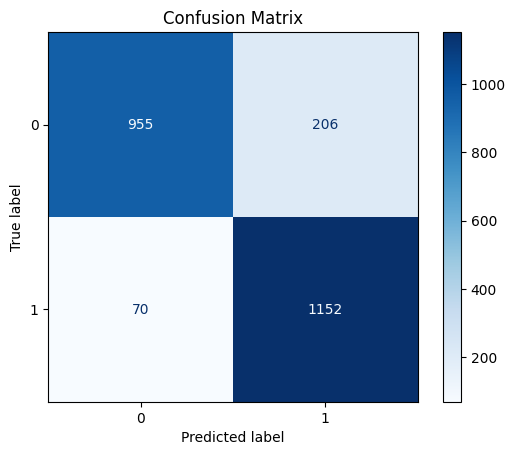

In [47]:
# confusion metric
cm = confusion_matrix(y_test, y_pred_class_tuned)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


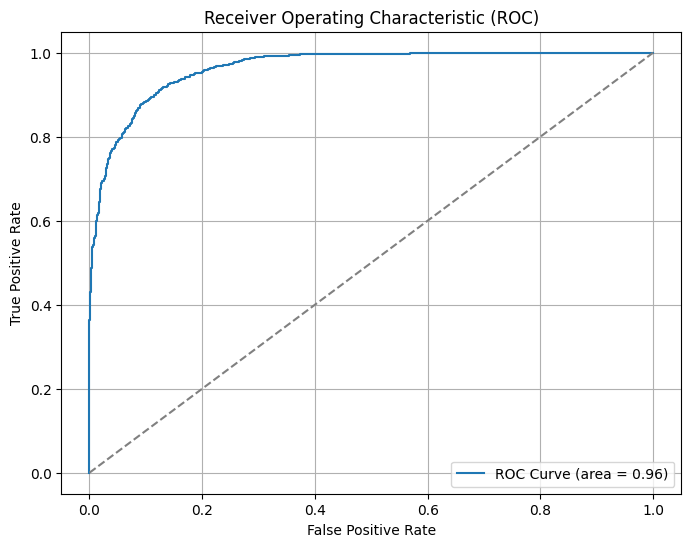

In [48]:
# Calculate ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_tuned)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

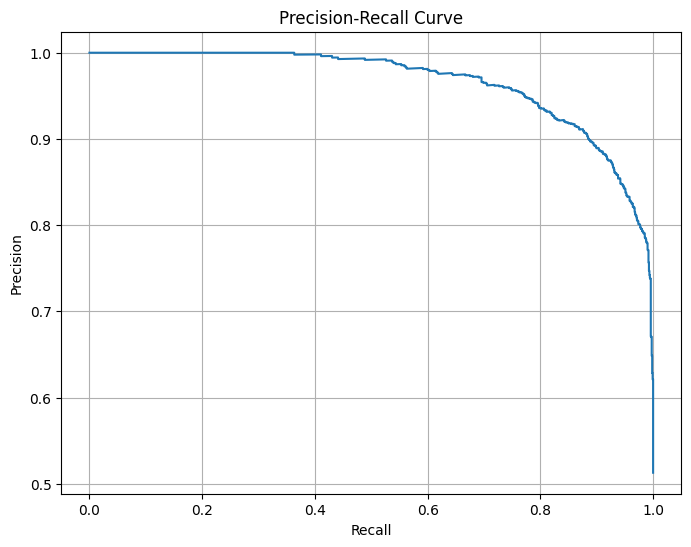

In [49]:
# precision recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_tuned)

plt.figure(figsize=(8,6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()


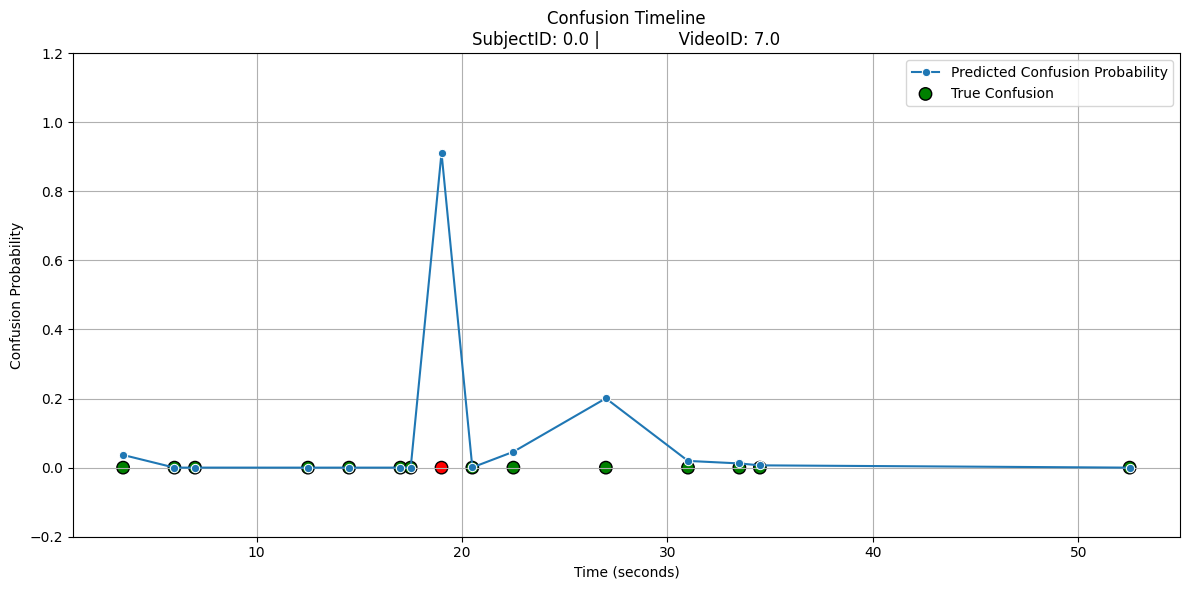

In [50]:
# confusion: predicted vs true
result_df_visual = pd.read_csv('test_results.csv')

# Function to plot confusion timeline
def plot_confusion_timeline(result_df, subject_id, video_id):
    subset = result_df[(result_df['SubjectID'] == subject_id)
                        & (result_df['VideoID'] == video_id)]
    
    if subset.empty:
        print(f"No data found for SubjectID={subject_id} \
               and VideoID={video_id}")
        return

    subset = subset.sort_values('Timestamp_sec')

    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Timestamp_sec', y='Predicted_Prob_tuned', 
                 data=subset, marker='o', 
                 label='Predicted Confusion Probability')

    # Mark True Labels
    colors = ['green' if row['True_Label'] == row['Predicted_Label_tuned'] 
              else 'red' for idx, row in subset.iterrows()]
    plt.scatter(subset['Timestamp_sec'], subset['True_Label'], 
                c=colors, s=80, edgecolors='black', label='True Confusion')

    plt.title(f"Confusion Timeline\nSubjectID: {subject_id} | \
              VideoID: {video_id}")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Confusion Probability')
    plt.ylim([-0.2, 1.2])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_confusion_timeline(result_df_visual, subject_id=0.0, video_id=7.0)